# Mall Customer Segmentation using K-Means Clustering

`Author:` [Sagar Kanekar](https://github.com/TheShade1551)\
`Date:` 14.December.2024\
`Dataset:`[Mall Customers Dataset](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data)

### About Dataset(Meta Data)

#### Context:-
- Following Dataset is a Collection of Customer Data of a Supermarket Mall obtained through Membership Cards.
- This Dataset Contains 5 Attributes(4 Raw & 1 Derived) & is meant to be used for Customer Segmentation & Market-Basket-Analysis.

#### Content:-
- The Raw Attributes Present in the Dataset are as Follows:-
  1. Customer_ID:- Indexing of the Customers Based on thier Membership Entries
  2. Gender:- Gender of the Customer
  3. Age:- Age of the Customer
  4. Annual_Income:- Annual Income of the Customer(in 1000$)
- Based on Customer Behaviour & Purchasing Data, following attribute is derived.
  - Spending Score - Score assigned by the mall based on customer behavior and spending nature(Range between 1 to 100)

### Acknowledgements:-
- The Mall Customer Dataset was obtained from Udemy's Machine Learning A-Z course.
- The Dataset is Made Available by Kaggle through Open Competition.

---
### Problem Statement:-
- To Create a K-Means Clustering Algorithm to Group Customers of a Mall Supermarket based on their Purchase History:-

# `Import Libraries`

In [147]:
# Data Manipulation & Analysis
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning Tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# `Load Dataset`

In [148]:
# Loading Dataset
df = pd.read_csv('Mall_Customers.csv')

In [149]:
df.sample(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
10,11,Male,67,19,14
189,190,Female,36,103,85
88,89,Female,34,58,60
73,74,Female,60,50,56
101,102,Female,49,62,48


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [151]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Mean of Spending Score is 50. Which Can be Improved by Removing Customers with Very Low Spending Scores.

In [152]:
mask = df.loc[:, 'Spending Score (1-100)'] < 30
mask.sum()

46

46 Customers have a Spending Score of Less than 30. These Can be ignored for Better Basket Analysis.

In [153]:
df1 = df.loc[~mask, :]

In [154]:
df1.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,154.000000,154.000000,154.000000,154.000000
mean,95.298701,37.603896,58.331169,60.941558
std,53.073525,14.219300,23.651902,18.526165
min,1.000000,18.000000,15.000000,31.000000
25%,54.250000,27.000000,43.000000,46.000000
50%,92.500000,34.000000,59.500000,56.000000
75%,133.750000,48.000000,72.000000,75.000000
max,200.000000,70.000000,137.000000,99.000000


In [155]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


No Missing Values in Data.

# `Exploratory Data Analysis`

In [156]:
# Understanding Gender Distribution
fig = px.pie(df, names='Gender',title= 'Gender-Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

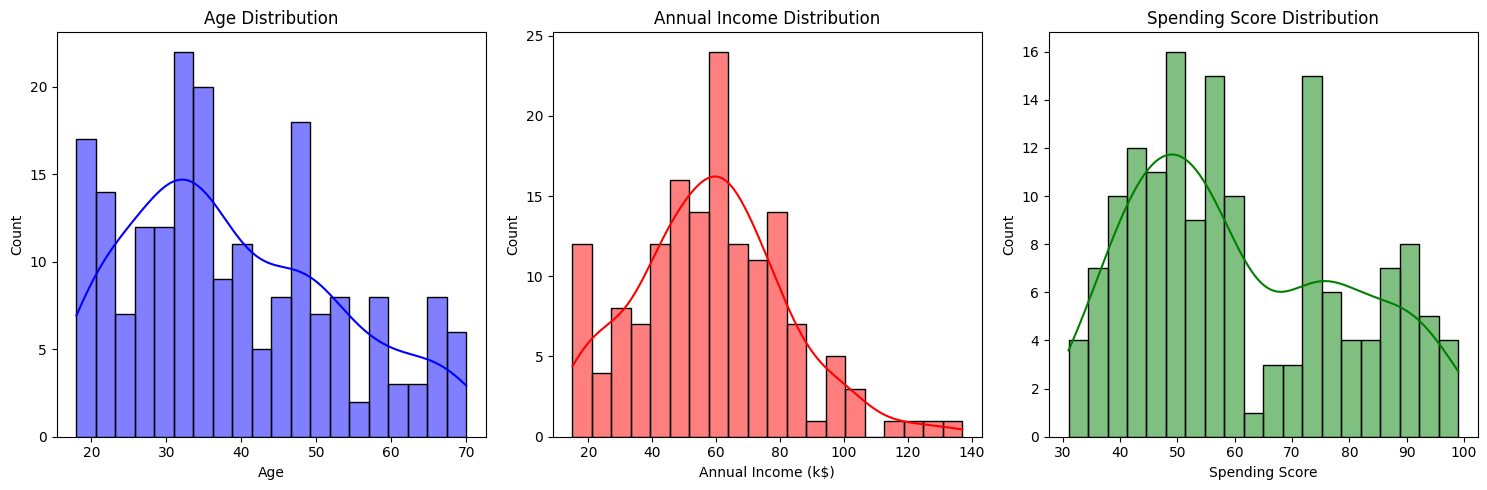

In [157]:
# Understanding Spread of Numerical Features
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.histplot(df['Age'], kde=True, bins=20, color='blue', ax=axs[0])
axs[0].set_title('Age Distribution')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Count')

sns.histplot(df1['Annual Income (k$)'], kde=True, bins=20, color='red', ax=axs[1])
axs[1].set_title('Annual Income Distribution')
axs[1].set_xlabel('Annual Income (k$)')
axs[1].set_ylabel('Count')

sns.histplot(df1.loc[:, 'Spending Score (1-100)'], kde=True, bins=20, color='green', ax=axs[2])
axs[2].set_title('Spending Score Distribution')
axs[2].set_xlabel('Spending Score')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

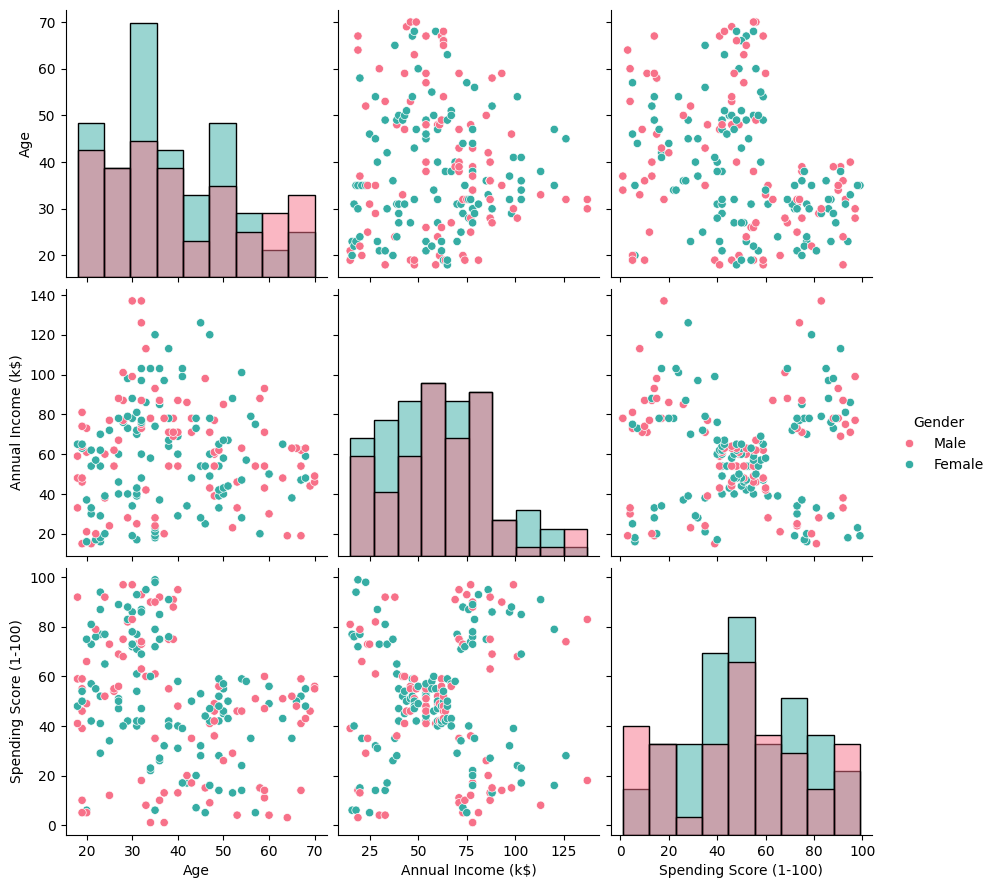

In [158]:
df_pair = df.loc[:, ['Gender','Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
sns.pairplot(df_pair, hue="Gender", diag_kind="hist", palette="husl", height=3)
plt.show()

**Observations from EDA**
- `Gender`:- Female Customers are More than Male Customers by a Significant Margin.
- `Age`:- Distribution is Skewed a bit towards Young Audience Between age 18-40. But There is Still a Significant Amount of Customers within Older Age Categories.
- `Annual Income`:- Annual Income of Customers shows a Normal-Distribution of Mean Annual Income Being 60k$
- `Spending Score`:- Feature Shows a Bimodal Distribution. Hinting a Clear Distinction between two Types of Customers.
  1. With Spending Score - Less than 60
  2. With Spending Score - Greater than 60.
- Features `Annual Income` & `Spending Score` Show


# `Determining Optimal Number of Clusters `

In [159]:
# Creating a Dataframe to Fit the Model
X = df.iloc[:, [3,4]]
X.shape

(200, 2)

In [160]:
# Using Elbow Method & Silhouete Score to Determine Optimal Number of Clusters
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []
for n in n_clusters:
    model = KMeans(n_clusters=n, random_state=42)
    model.fit(X)
    inertia_errors.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X, model.labels_))

Text(0, 0.5, 'Silhouette Score')

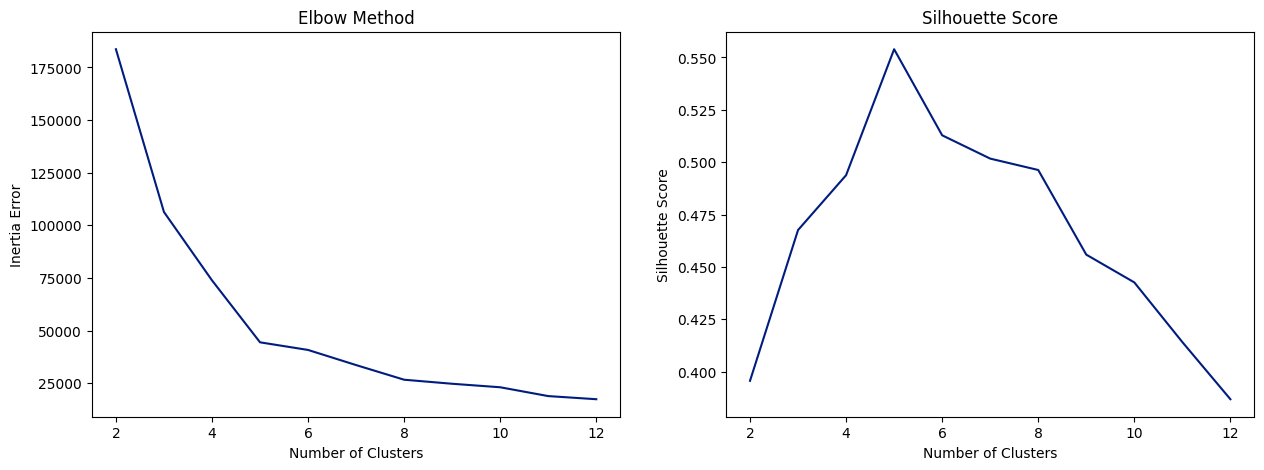

In [161]:
fig, axs= plt.subplots(1,2, figsize=(15,5))
sns.lineplot(x=n_clusters, y=inertia_errors, ax=axs[0])
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Inertia Error')

sns.lineplot(x=n_clusters, y=silhouette_scores, ax=axs[1])
axs[1].set_title('Silhouette Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Silhouette Score')

In [162]:
# Visualising Elbow Method & Silhouette Score using Plotly

import plotly.graph_objects as go
from plotly.subplots import make_subplots

n_clusters = list(n_clusters)
fig = make_subplots(rows=1, cols=2, subplot_titles=("Elbow Method", "Silhouette Score"))

fig.add_trace(go.Scatter(x=n_clusters, y=inertia_errors), row=1, col=1)
fig.add_trace(go.Scatter(x=n_clusters, y=silhouette_scores), row=1, col=2)

fig.update_layout(title_text='Optimal Number of Clusters', showlegend=False)
fig.show()


**Optimal Number of Clusters:-5**

In [163]:
# Fitting Data onto Final Model
model = KMeans(n_clusters=5, random_state=42)
model.fit(X)

KMeans(n_clusters=5, random_state=42)

In [164]:
# assigning clusters(0-4) to each datapoint
labels = model.labels_

# storing each cluster's centroid
centroids = model.cluster_centers_

# checking the assigned clusters of First 5 Datapoints
print(labels[:5])

[4 2 4 2 4]


Text(0, 0.5, 'Spending Score (1-100)')

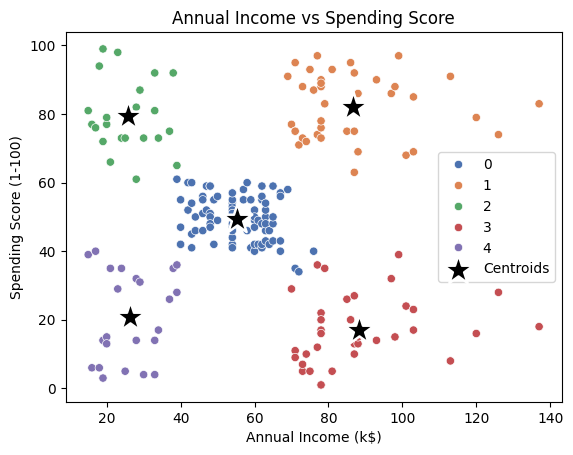

In [165]:
# Plotting "Annual Income" vs "Spending Score"
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=labels, palette='deep')

sns.scatterplot(
    x = centroids[:,0],
    y = centroids[:,1],
    s = 500,
    c = 'black',
    marker = '*',
    label = 'Centroids'
)
plt.title('Annual Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

In [166]:
# Checking Number of Points Within Each Clusters
clustered_data = pd.DataFrame({'Cluster': labels, 'Data': X.index})
cluster_counts = clustered_data.groupby('Cluster')['Data'].count()
print(cluster_counts)

Cluster
0    81
1    39
2    22
3    35
4    23
Name: Data, dtype: int64


In [167]:
# Creating side-by-side bar chart of `xgb`
xgb= X.groupby(model.labels_).mean()
fig = px.bar(
    xgb,
    barmode= 'group',
    title= "Annual income and spending score by Cluster"
)
fig.update_layout(xaxis_title= "Clusters" , yaxis_title= 'Value')

fig.show()

# `Conclusion`

Using K-Means Clustering The Given Customer Data was Divided into 5 Clusters.
 1. Cluster 0 :- `Average-Expenditure` :- Customers with Average Annual Income of 50K$ & have a Spending Score ~ 50.
 2. Cluster 1:- `High-Expenditure` :- Customers with High Annual Income & High Spending Score
 3. Cluster 2:- `Passionates`:- Customers with Lower Annual Income than Average Yet Higher Spending Score.
 4. Cluster 3:- `Low-Spenders`:- Customers with Higher Annual Income than average yet Lower Spending Score.
 5. Cluster 4:- `Low-Expenditure`:- Customers with Lower Annual Income & Lower Spending Score.

### Conclusion
- K-Means Clustering Model was Successfully fit on `Mall Customers Dataset` to Group Customers of a Mall Supermarket based on their `Annual Income` & `Expenditure`.